In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE

In [2]:
# seed, 29, 13
seed = 17
np.random.seed(seed)

In [3]:
cifar_10_dir = 'cifar-10-batches-py'
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10():
    x_train = []
    y_train = []
    for i in range(1, 6):
        batch = unpickle(cifar_10_dir + '/data_batch_' + str(i))
        x_train.append(batch[b'data'])
        y_train.append(batch[b'labels'])
    x_train = np.concatenate(x_train)
    y_train = np.concatenate(y_train)
    test_batch = unpickle(cifar_10_dir + '/test_batch')
    x_test = np.array(test_batch[b'data'])
    y_test = np.array(test_batch[b'labels'])

    # reshape to 3x32x32
    x_train = x_train.reshape(-1, 3, 32, 32)
    x_test = x_test.reshape(-1, 3, 32, 32)

    # transpose to 32x32x3
    x_train = x_train.transpose(0, 2, 3, 1)
    x_test = x_test.transpose(0, 2, 3, 1)

    return x_train, y_train, x_test, y_test

def normalize(x):
    return x / 255.0

def shuffle(x, y):
    indices = np.random.permutation(len(x))
    return x[indices], y[indices]

x_train, y_train, x_test, y_test = load_cifar10()
x_train = normalize(x_train)
x_test = normalize(x_test)

# shuffle
x_train, y_train = shuffle(x_train, y_train)

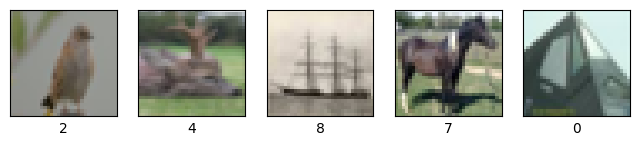

In [4]:
# plot 5 image in a row, with label
def plot_images(images, labels):
    fig, axes = plt.subplots(1, 5, figsize=(8, 40))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_xlabel(labels[i])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

plot_images(x_train[:5], y_train[:5])

## 1

In [5]:
# Non - linearity
class NonLinearity:
    def __init__(self, name):
        self.name = name

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def ReLU(self, x):
        return np.maximum(0, x)
    
    def tanh(self, x):
        return np.tanh(x)
    
    def PReLU(self, x, alpha):
        return np.maximum(0, x) + alpha * np.minimum(0, x)
    
    def forward(self, x):
        if self.name == 'sigmoid':
            return self.sigmoid(x)
        elif self.name == 'ReLU':
            return self.ReLU(x)
        elif self.name == 'tanh':
            return self.tanh(x)
        elif self.name == 'PReLU':
            return self.PReLU(x, 0.01)
        elif self.name == 'No':
            return x
        else:
            raise ValueError(f'Invalid non-linearity {self.name}')

In [6]:
class getKernel:
    def __init__(self, name):
        self.name = name
    
    def forward(self, kernel_size):
        if self.name == 'identity':
            kernel = np.zeros((kernel_size, kernel_size))
            kernel[kernel_size // 2, kernel_size // 2] = 1
        elif self.name == 'sharpen':
            kernel = np.zeros((kernel_size, kernel_size))
            kernel -= np.ones((kernel_size, kernel_size))
            kernel[kernel_size // 2, kernel_size // 2] = kernel_size ** 2
        elif self.name == 'gaussian':
            kernel = np.zeros((kernel_size, kernel_size))
            for i in range(kernel_size):
                for j in range(kernel_size):
                    kernel[i, j] = np.exp(-((i - kernel_size // 2) ** 2 + (j - kernel_size // 2) ** 2) / (2 * 1.0))
            kernel /= np.sum(kernel)
        else:
            raise ValueError(f'Invalid kernel {self.name}')
        
        return kernel

1. **Convolution Function**

In [7]:
def conv_func(img, kernel, stride, padding, activation):
    # Get the dimensions of the image and the kernel
    img_h, img_w = img.shape[0], img.shape[1]
    kernel_h, kernel_w = kernel.shape[0], kernel.shape[1]
    cnl = img.shape[2]
    
    if (cnl != kernel.shape[2]):
        raise ValueError(f'Number of channels in the image and kernel do not match')
    if (kernel_h != kernel_w):
        raise ValueError(f'Kernel must be square')

    if (stride == 0):
        stride = 1
    
    # Calculate the dimensions of the output image
    out_h = (img_h - kernel_h + 2 * padding) // stride + 1
    out_w = (img_w - kernel_w + 2 * padding) // stride + 1
    
    # Create an empty image to store the output
    out = np.zeros((out_h, out_w))
    
    # do padding with zeros
    pad_img = np.zeros((img_h + 2 * padding, img_w + 2 * padding, cnl))
    pad_img[padding:padding + img_h, padding:padding + img_w] = img

    # Convolve the image with the kernel
    for i in range(0, out_h):
        for j in range(0, out_w):
            out[i, j] = np.sum(pad_img[i * stride:i * stride + kernel_h, j * stride:j * stride + kernel_w, :] * kernel)

    # non-linearity
    nl = NonLinearity(activation)

    # add one more dimension for channel
    out = out[:, :, np.newaxis]

    return nl.forward(out)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.161749444226285..2.203394315158838].


Image shape: (32, 32, 3)
Kernel shape: (3, 3, 3)


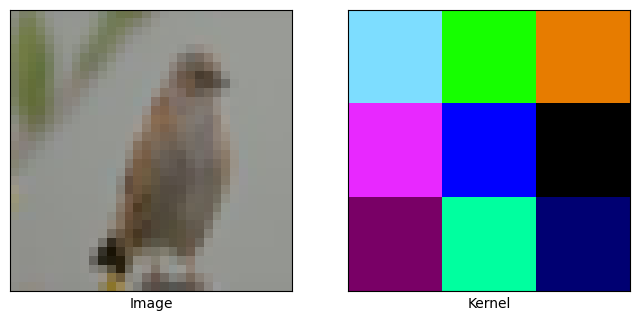

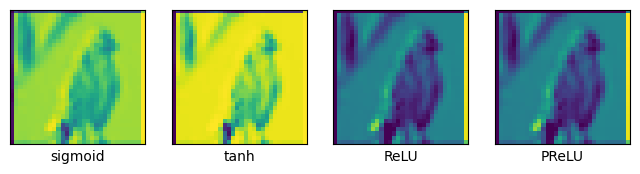

In [8]:
img = x_train[0]
print(f'Image shape: {img.shape}')

# kernel = getKernel('gaussian').forward(3)
# make 3x3 kernel
# kernel = np.stack([kernel, kernel, kernel], axis=2)

# random kernel with 3 channels
kernel = np.random.randn(3, 3, 3)
print(f'Kernel shape: {kernel.shape}')

# get output for 4 different activation functions
activation = ['sigmoid', 'tanh', 'ReLU', 'PReLU']

# plot image and kernel
fig, axes = plt.subplots(1, 2, figsize=(8, 40))
axes[0].imshow(img)
axes[0].set_xlabel('Image')
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].imshow(kernel)
axes[1].set_xlabel('Kernel')
axes[1].set_xticks([])
axes[1].set_yticks([])
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(8, 40))
for i, ax in enumerate(axes.flat):
    out = conv_func(img, kernel, 1, 1, activation[i])
    ax.imshow(out)
    ax.set_xlabel(activation[i])
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

2. **Pooling Layer**

In [9]:
def pooling_func(img, k_sz, stride, pool):
    if (pool == 'max'):
        pool_f = lambda x: np.max(x)
    elif (pool == 'average'):
        pool_f = lambda x: np.mean(x)
    else:
        raise ValueError(f'Invalid pooling function {pool}')
    
    # Get the dimensions of the image
    img_h, img_w, img_c = img.shape

    if (stride == 0):
        stride = 1

    # Calculate the dimensions of the output image
    out_h = (img_h - k_sz) // stride + 1
    out_w = (img_w - k_sz) // stride + 1

    # Create an empty image to store the output
    out = np.zeros((out_h, out_w, img_c))

    # Pool the image
    for i in range(0, out_h):
        for j in range(0, out_w):
            out[i, j, :] = pool_f(img[i * stride:i * stride + k_sz, j * stride:j * stride + k_sz, :])

    # normalize the output
    out = out / np.max(out)

    return out

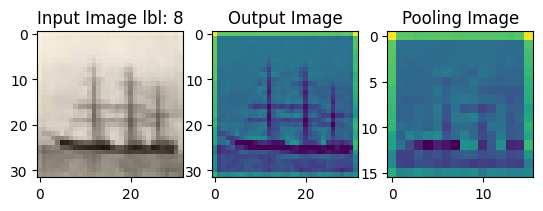

In [10]:
# make edge filter kernel of shape 3x3x3
# kernel = np.array([[[1, 0, -1], [1, 0, -1], [1, 0, -1]],
#                    [[1, 0, -1], [1, 0, -1], [1, 0, -1]],
#                    [[1, 0, -1], [1, 0, -1], [1, 0, -1]]])
idx = 2
img = x_train[idx]
kernel = getKernel('sharpen').forward(3)
for i in range(img.shape[2] - 1):
    kernel = np.dstack((kernel, getKernel('gaussian').forward(3)))
stride = 1
padding = kernel.shape[0] // 2
activation = 'ReLU'
out = conv_func(img, kernel, stride, padding, activation)

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title(f'Input Image lbl: {y_train[idx]}')
plt.subplot(1, 3, 2)
plt.imshow(out)
plt.title('Output Image')

# Pooling
k_sz = 2
stride = 2
pool = 'max'
out = pooling_func(out, k_sz, stride, pool)

plt.subplot(1, 3, 3)
plt.imshow(out)
plt.title('Pooling Image')
plt.show()


3. **Convolution Layer**

In [11]:
class conv_layer:
    def __init__(self, kernel_sz, n_kernels, stride, padding, activation):
        self.kernel_sz = kernel_sz
        self.n_kernels = n_kernels
        self.stride = stride
        self.padding = padding
        self.activation = activation
        

    def forward(self, img, kernel_type='random', plot_stat=False):
        out = []
        if (plot_stat):
            fig, axes = plt.subplots(2, self.n_kernels, figsize=(10, 5))
        for i in range(self.n_kernels):
            if (kernel_type=='random'): kernel = np.random.rand(self.kernel_sz, self.kernel_sz, img.shape[2])
            else:
                kernel = getKernel(kernel_type).forward(self.kernel_sz)
                kernel = np.stack([kernel, kernel, kernel], axis=2)
        
            out.append(conv_func(img, kernel, self.stride, self.padding, self.activation))
            if plot_stat:
                axes[0, i].imshow(kernel)
                axes[0, i].set_xlabel(f'Kernel {i}')
                axes[0, i].set_xticks([])
                axes[0, i].set_yticks([])
                axes[1, i].imshow(out[i])
                axes[1, i].set_xlabel(f'Output {i}')
                axes[1, i].set_xticks([])
                axes[1, i].set_yticks([])
        if plot_stat: plt.show()

        out = np.concatenate(out, axis=2)
        return out

Image shape: (32, 32, 3)


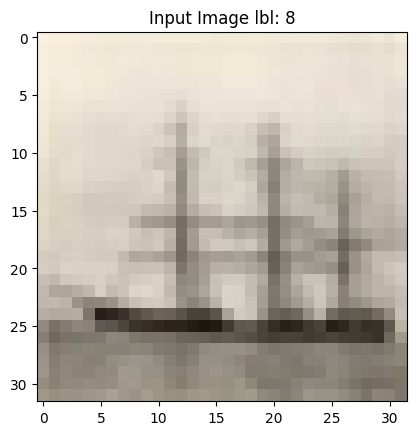

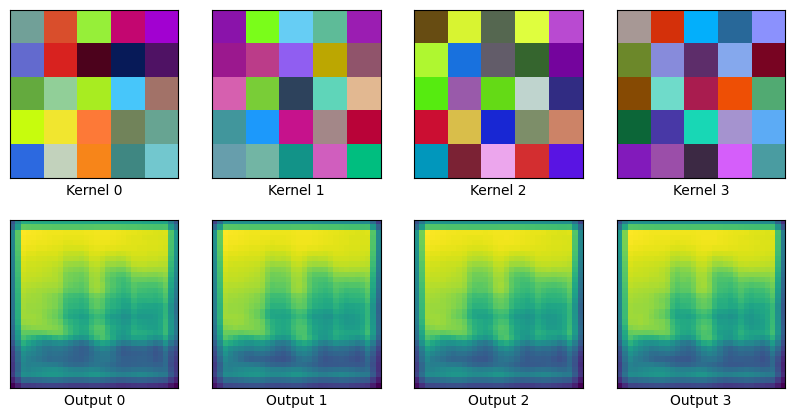

Output shape: (32, 32, 4)


In [12]:
# display input image, kernel and output image
idx = 2
img = x_train[idx]
print(f'Image shape: {img.shape}')
plt.imshow(img)
plt.title(f'Input Image lbl: {y_train[idx]}')
plt.show()

# make kernel of shape 3x3x3
kernel_sz = 5
n_kernels = 4
stride = 1
padding = kernel_sz // 2
activation = 'ReLU'
conv = conv_layer(kernel_sz, n_kernels, stride, padding, activation)

out = conv.forward(img, 'random', True)
print(f'Output shape: {out.shape}')

4. **Pooling Layer**

In [13]:
class pool_layer:
    def __init__(self, sz, pool_f, stride):
        self.sz = sz
        self.pool_f = pool_f
        self.stride = stride

    def forward(self, img):
        return pooling_func(img, self.sz, self.stride, self.pool_f)

Image shape: (32, 32, 3)


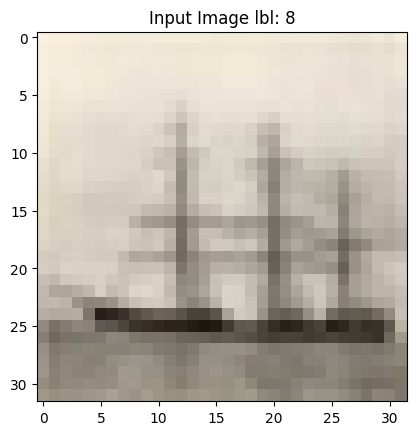

<Figure size 1000x500 with 0 Axes>

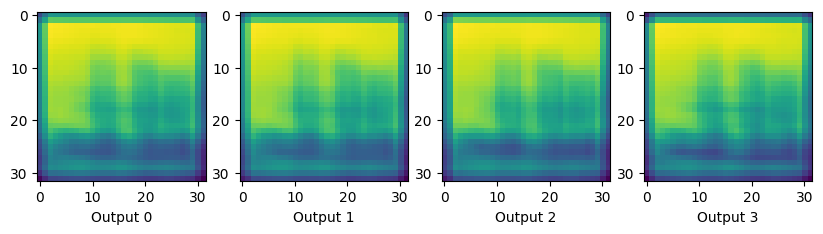

<Figure size 1000x500 with 0 Axes>

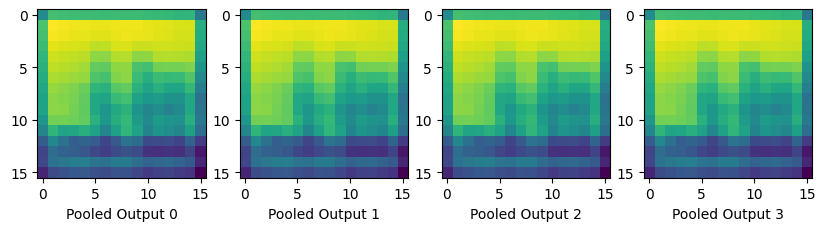

In [14]:
idx = 2
img = x_train[idx]
print(f'Image shape: {img.shape}')
plt.imshow(img)
plt.title(f'Input Image lbl: {y_train[idx]}')

# Convolution
kernel_sz = 5
n_kernels = 4
stride = 1
padding = kernel_sz // 2
activation = 'ReLU'
conv = conv_layer(kernel_sz, n_kernels, stride, padding, activation)
out = conv.forward(img, 'random', False)

# plot output of convolution
plt.figure(figsize=(10, 5))
fig, axes = plt.subplots(1, n_kernels, figsize=(10, 5))
for i in range(n_kernels):
    axes[i].imshow(out[:, :, i])
    axes[i].set_xlabel(f'Output {i}')
plt.show()

k_sz = 2
stride = 2
pool = 'max'
pool = pool_layer(k_sz, pool, stride)
out = pool.forward(out)

plt.figure(figsize=(10, 5))
fig, axes = plt.subplots(1, n_kernels, figsize=(10, 5))
for i in range(n_kernels):
    axes[i].imshow(out[:, :, i])
    axes[i].set_xlabel(f'Pooled Output {i}')
plt.show()


5. **Flattering Layer (unraveling)**

In [15]:
class flatten_layer:
    def __init__(self):
        pass

    def forward(self, x, out_sz, weightM = None):
        x_flatten = x.flatten()
        if weightM is None:
            self.weightM = np.random.rand(out_sz, x_flatten.shape[0])
        else :
            self.weightM = weightM
        return np.dot(self.weightM, x_flatten)

In [16]:
class linear():
    def __init__(self, in_feat, out_feat):
        self.W = np.random.randn(in_feat, out_feat) # see other initialization methods
        self.b = np.zeros((1, out_feat))

    def forward(self, X):
        self.X = X
        return np.dot(X, self.W) + self.b
    

6. **Multi-Layer Perceptron (MLP)**

In [17]:
class MLP:
    def __init__(self, input_sz, hidden_sz, n_hidden, output_sz, activation):
        self.layers = []
        self.layers.append(linear(input_sz, hidden_sz))
        self.layers.append(NonLinearity(activation))
        for i in range(n_hidden):
            self.layers.append(linear(hidden_sz, hidden_sz))
            self.layers.append(NonLinearity(activation))
        self.layers.append(linear(hidden_sz, output_sz))

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

In [18]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1)

In [19]:
img = x_train[0]
print(f'Image shape: {img.shape}')

conv1 = conv_layer(kernel_sz=5, n_kernels=4, stride=1, padding=5//2, activation='ReLU')
img = conv1.forward(img)
print(f'Image shape after convolution: {img.shape}')

pool1 = pool_layer(sz=2, pool_f='max', stride=2)
img = pool1.forward(img)
print(f'Image shape after pooling: {img.shape}')

conv2 = conv_layer(kernel_sz=5, n_kernels=4, stride=1, padding=5//2, activation='ReLU')
img = conv2.forward(img)
print(f'Image shape after convolution: {img.shape}')

pool2 = pool_layer(sz=2, pool_f='max', stride=2)
img = pool2.forward(img)
print(f'Image shape after pooling: {img.shape}')

flatten = flatten_layer()
img = flatten.forward(img, 8*8*4)
print(f'Image shape after flattening: {img.shape}')

mlp = MLP(input_sz=8*8*4, hidden_sz=49, n_hidden=2, output_sz=10, activation='ReLU')
img = mlp.forward(img)
print(f'Image shape after MLP: {img.shape}')

# normalize
img = (img - np.mean(img)) / np.std(img)

print(img)
# softmax
img = softmax(img)
print(f'Image shape after softmax: {img.shape}')


Image shape: (32, 32, 3)
Image shape after convolution: (32, 32, 4)
Image shape after pooling: (16, 16, 4)
Image shape after convolution: (16, 16, 4)
Image shape after pooling: (8, 8, 4)
Image shape after flattening: (256,)
Image shape after MLP: (1, 10)
[[ 0.03251241 -1.22850203  0.4165509   1.08846212  1.02060531 -1.49666635
   1.60569574 -0.13729859 -1.10120051 -0.20015901]]
Image shape after softmax: (1, 10)


7. **Feed Forward path**

In [20]:
class CNN_custom:
    def __init__(self):
        self.layers = []
        self.conv = conv_layer(kernel_sz=5, n_kernels=4, stride=1, padding=5//2, activation='ReLU')
        self.pool = pool_layer(2, 'max', 2)
        self.flatten = flatten_layer()
        self.fc = MLP(8*8*4, 49, 1, 10, 'ReLU')

    def forward(self, X):
        X = self.conv.forward(X)
        X = self.pool.forward(X)
        X = self.conv.forward(X)
        X = self.pool.forward(X)
        X = self.flatten.forward(X, 8*8*4)
        X = self.fc.forward(X)
        
        # normalize
        X = (X - np.mean(X)) / np.std(X)

        # softmax
        X = softmax(X)

        return X



Image shape: (32, 32, 3)
Image shape after CNN: (32, 32, 3)


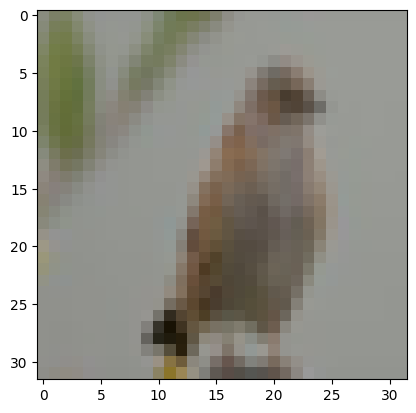

Output :[[0.06826348 0.09536016 0.01202113 0.10494273 0.16348879 0.02424342
  0.01634873 0.22459678 0.22242975 0.06830503]]


In [21]:
model = CNN_custom()
img = x_train[0]
print(f'Image shape: {img.shape}')

out = model.forward(img)
print(f'Image shape after CNN: {img.shape}')

plt.imshow(img)
plt.show()

print(f'Output :{out}')


In [22]:
# data :- get n images from each class
def get_data(x, y, n):
    X, Y = [], []
    for i in range(10):
        idx = np.where(y == i)[0][:n]
        X.append(x[idx])
        Y.append(y[idx])
    X = np.concatenate(X)
    Y = np.concatenate(Y)

    return X, Y

X_tr, y_tr = get_data(x_train, y_train, 100)
X_te, y_te = get_data(x_test, y_test, 10)

8 (a)

Class: 0


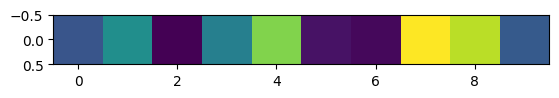

Class: 1


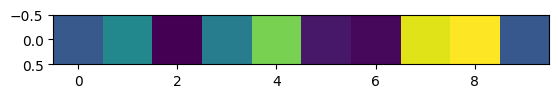

Class: 2


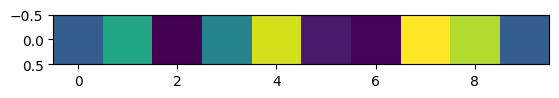

Class: 3


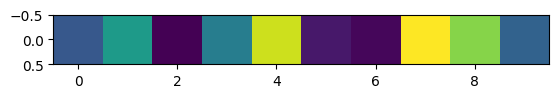

Class: 4


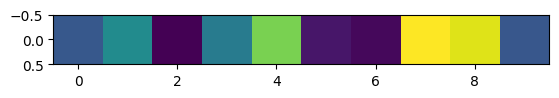

Class: 5


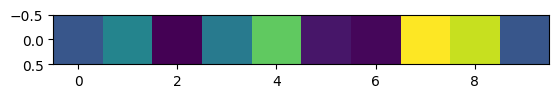

Class: 6


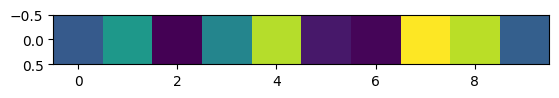

Class: 7


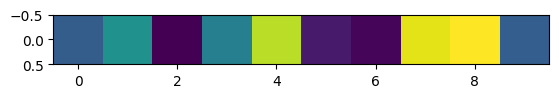

Class: 8


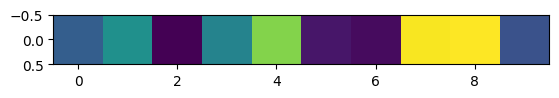

Class: 9


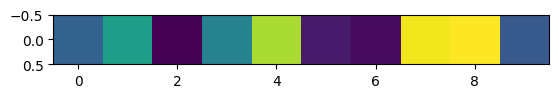

In [23]:
X_1, y_1 = get_data(x_train, y_train, 1)

for i in range(len(X_1)):
    
    out = model.forward(X_1[i])
    print(f'Class: {y_1[i]}')
    plt.imshow(out)
    plt.show()


- All the output vectors are almost the same.
- This is because inferenece using random kernels.

8 (b)

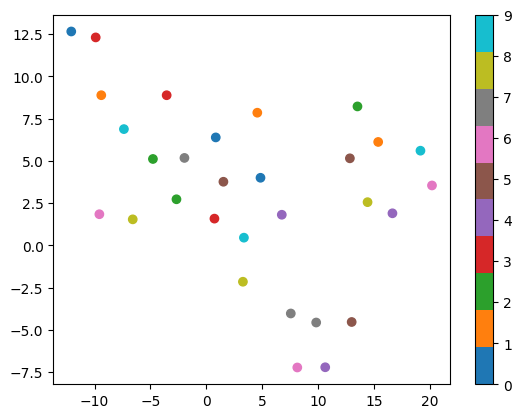

In [24]:
X_3, y_3 = get_data(x_train, y_train, 3)

out_3 = []
for i in range(len(X_3)):
    out = model.forward(X_3[i])
    out_3.append(out)

# color for 10 classes
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']

# tsne
out_3 = np.concatenate(out_3)
out_embedded = TSNE(n_components=2, perplexity=10).fit_transform(out_3)

plt.scatter(out_embedded[:, 0], out_embedded[:, 1], c=y_3, cmap='tab10')
plt.colorbar()
plt.show()

- Randomly initialized network here don't show any discrimiability between the classes.
- Classes are not linearly separable as shown in the figure.

## 2

1. CNN Pytorch

In [25]:
# pytorch cnn model
class CNN_pytorch(nn.Module):
    def __init__(self, dropout=None, batch_norm=False):
        super(CNN_pytorch, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=5, stride=1, padding=5//2)
        self.pool = nn.MaxPool2d((2, 2), 2)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=5, stride=1, padding=5//2)
        self.fc = nn.Linear(4 * 8 * 8, 49)
        self.fc2 = nn.Linear(49, 10)
        self.dropout = dropout
        self.batch_norm = batch_norm

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # x = x.view(-1, 4 * 8 * 8)
        x = torch.flatten(x, 1)
        if (self.dropout is not None):
            # x = F.dropout(x, self.dropout, training=self.training)
            x = nn.Dropout(self.dropout)(x)
        x = self.fc(x)
        if self.batch_norm:
            x = nn.BatchNorm1d(49)(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [26]:
model = CNN_pytorch()
img = x_train[0]
print(f'Image shape: {img.shape}')

img = torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float()
out = model.forward(img)
print(f'Image shape after CNN: {out.shape}')

Image shape: (32, 32, 3)
Image shape after CNN: torch.Size([1, 10])


2. Train with differrent optimizers

In [27]:
# cross entropy loss
criterion = nn.CrossEntropyLoss()

In [28]:
# test
def test(model, X, y, batch_sz, print_acc=False):
    acc = 0.0
    err = 0.0
    model.eval()
    for i in range(0, len(X), batch_sz):
        x = torch.tensor(X[i:i+batch_sz]).permute(0, 3, 1, 2).float()
        y_ = torch.tensor(y[i:i+batch_sz])
        out = model.forward(x)

        loss = criterion(out, y_)
        err += loss.item()

        _, predicted = torch.max(out.data, 1)
        correct = (predicted == y_).sum().item()
        acc += correct

    acc = acc / len(X)
    err = err / len(X) * batch_sz
    if (print_acc): print(f'Test Accuracy: {acc}')
    return err, acc

In [29]:
# visualize activation maps
def visualize_activation_map(model, img, lbl):
    model.eval()
    img = torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float()
    out = model.conv1(img)
    out1 = model.pool(out)

    out = model.conv2(out1)
    out2 = model.pool(out)

    out = out2.view(-1, 4 * 8 * 8)
    out = model.fc(out)
    out = F.relu(out)
    out = model.fc2(out)

    out = out.detach().numpy()
    out = softmax(out)

    # plot 4 activation maps of 1st layer
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    # title
    fig.suptitle(f'Activation Map for 1st conv, pool layer')
    for i in range(4):
        axes[i].imshow(out1[0, i].detach().numpy())
        axes[i].set_xlabel(f'Activation Map {i}')
    plt.show()

    # plot 4 activation maps of 2nd layer
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    fig.suptitle(f'Activation Map for 2nd conv, pool layer')
    for i in range(4):
        axes[i].imshow(out2[0, i].detach().numpy())
        axes[i].set_xlabel(f'Activation Map {i}')
    plt.show()

In [30]:
# mini-batch sgd train
def train(model, optimizer, criterion, X, y, batch_sz, n_epoch, print_stats=False, batch_sz_test=10, plot_stat=False):
    err_train, acc_train = [], []
    err_test, acc_test = [], []
    for epoch in range(n_epoch):
        # shuffle
        X, y = shuffle(X, y)
        acc = 0.0
        err = 0.0
        model.train()
        for i in range(0, len(X), batch_sz):
            x = torch.tensor(X[i:i+batch_sz]).permute(0, 3, 1, 2).float()
            y_ = torch.tensor(y[i:i+batch_sz])
            optimizer.zero_grad()
            out = model.forward(x)
            loss = criterion(out, y_)
            loss.backward()
            optimizer.step()
            err += loss.item()

            # accuracy
            _, predicted = torch.max(out.data, 1)
            correct = (predicted == y_).sum().item()
            acc += correct

        acc = acc / len(X)
        err = err / len(X) * batch_sz
        test_err, test_acc = test(model, X_te, y_te, batch_sz=batch_sz_test)

        acc_train.append(acc)
        err_train.append(err)

        acc_test.append(test_acc)
        err_test.append(test_err)

        if (print_stats): print(f'Epoch: {epoch}, Loss: {err}, Accuracy: {acc}, Test Loss: {test_err}, Test Accuracy: {test_acc}')

        if (plot_stat): 
            print(f'Epoch: {epoch}')
            visualize_activation_map(model, X[0], y[0])
            print()
    return err_train, acc_train, err_test, acc_test

In [31]:
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [32]:
epochs = 50
batch_sz_train = 100
batch_sz_test = 100

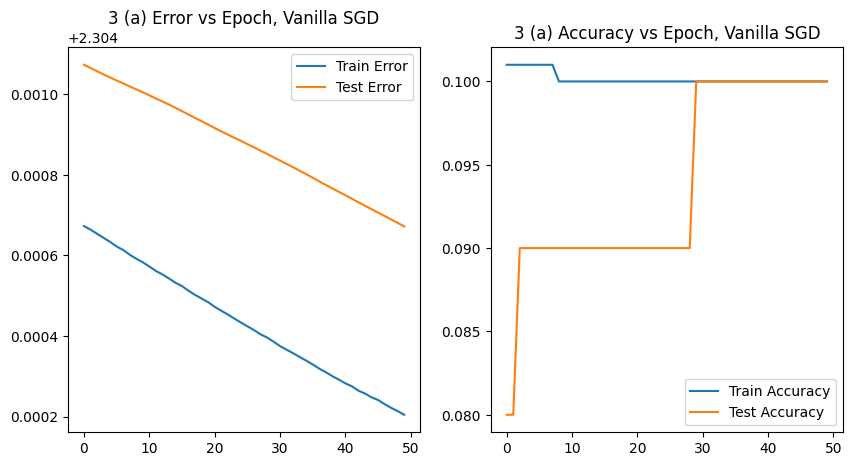

Final Train Accuracy after 50 epochs: 0.1
Final Test Accuracy after 50 epochs: 0.1


In [33]:
# train model with vanilla SGD
model = CNN_pytorch()
optimizer_a = optim.SGD(model.parameters(), lr=0.001)
err_train, acc_train, err_test, acc_test = train(model, optimizer_a, criterion, X_tr, y_tr, batch_sz_train, epochs, batch_sz_test=batch_sz_test)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# plot error_train and error_test
plt.plot(err_train, label='Train Error')
plt.plot(err_test, label='Test Error')
plt.legend()
plt.title('3 (a) Error vs Epoch, Vanilla SGD')

plt.subplot(1, 2, 2)
# plot acc_train and acc_test
plt.plot(acc_train, label='Train Accuracy')
plt.plot(acc_test, label='Test Accuracy')
plt.legend()
plt.title('3 (a) Accuracy vs Epoch, Vanilla SGD')

plt.show()

# print final train, test accuracy
print(f'Final Train Accuracy after {epochs} epochs: {acc_train[-1]}')

_, acc = test(model, X_te, y_te, batch_sz_test)
print(f'Final Test Accuracy after {epochs} epochs: {acc}')

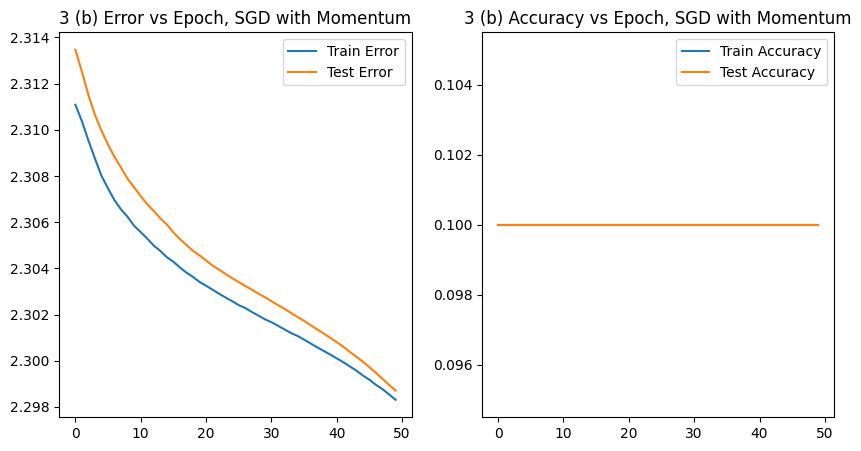

Final Train Accuracy after 50 epochs: 0.1
Final Test Accuracy after 50 epochs: 0.1


In [34]:
# train with momentum
model = CNN_pytorch()
optimizer_b = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
err_train, acc_train, err_test, acc_test = train(model, optimizer_b, criterion, X_tr, y_tr, batch_sz_train, epochs, batch_sz_test=batch_sz_test)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# plot error_train and error_test
plt.plot(err_train, label='Train Error')
plt.plot(err_test, label='Test Error')
plt.title('3 (b) Error vs Epoch, SGD with Momentum')
plt.legend()

plt.subplot(1, 2, 2)
# plot acc_train and acc_test
plt.plot(acc_train, label='Train Accuracy')
plt.plot(acc_test, label='Test Accuracy')
plt.title('3 (b) Accuracy vs Epoch, SGD with Momentum')
plt.legend()

plt.show()

# print final train, test accuracy
print(f'Final Train Accuracy after {epochs} epochs: {acc_train[-1]}')

_, acc = test(model, X_te, y_te, batch_sz_test)
print(f'Final Test Accuracy after {epochs} epochs: {acc}')

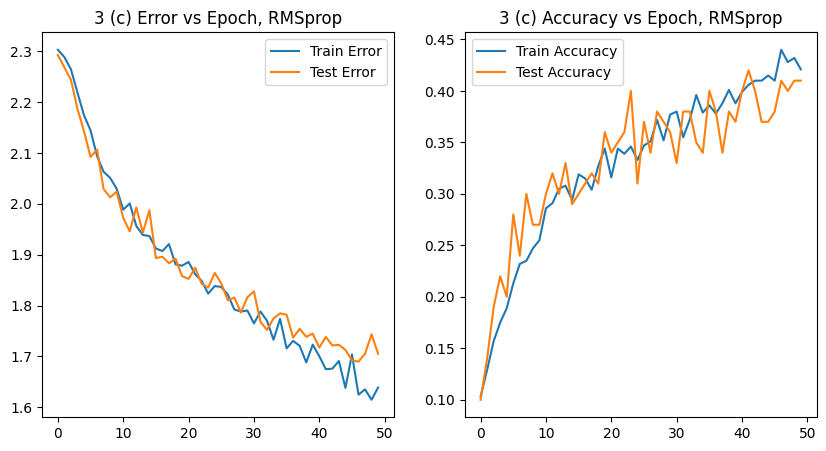

Final Train Accuracy after 50 epochs: 0.421
Final Test Accuracy after 50 epochs: 0.41


In [35]:
# train with rmsprop
model = CNN_pytorch()
optimizer_c = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)
err_train, acc_train, err_test, acc_test = train(model, optimizer_c, criterion, X_tr, y_tr, batch_sz_train, epochs, batch_sz_test=batch_sz_test)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# plot error_train and error_test
plt.plot(err_train, label='Train Error')
plt.plot(err_test, label='Test Error')
plt.title('3 (c) Error vs Epoch, RMSprop')
plt.legend()

plt.subplot(1, 2, 2)
# plot acc_train and acc_test
plt.plot(acc_train, label='Train Accuracy')
plt.plot(acc_test, label='Test Accuracy')
plt.title('3 (c) Accuracy vs Epoch, RMSprop')
plt.legend()

plt.show()

# print final test, train accuracy
print(f'Final Train Accuracy after {epochs} epochs: {acc_train[-1]}')

_, acc = test(model, X_te, y_te, batch_sz_test)
print(f'Final Test Accuracy after {epochs} epochs: {acc}')


Epoch: 0


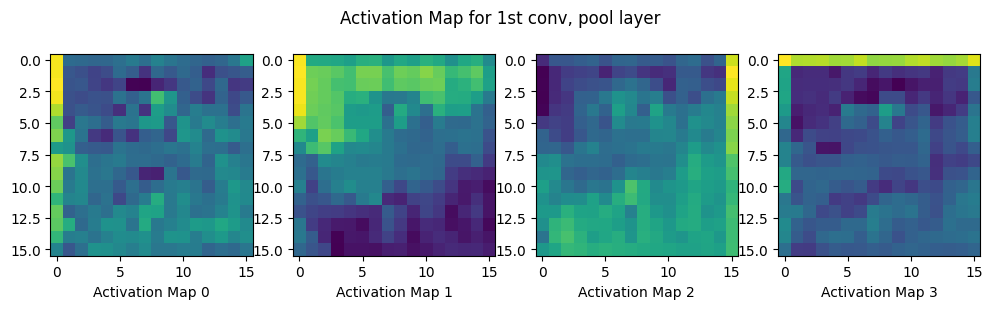

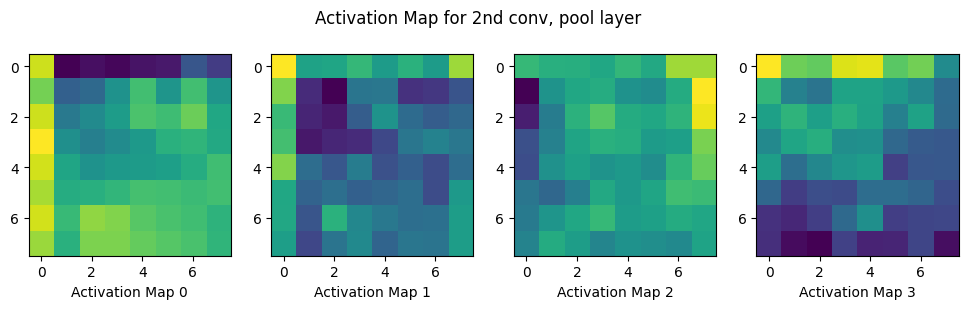


Epoch: 1


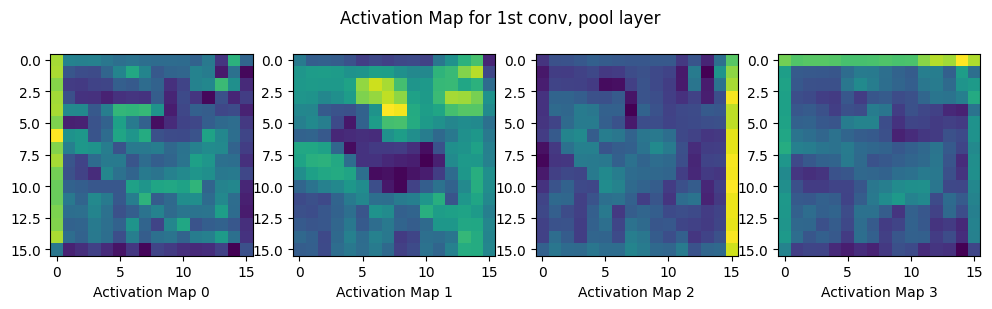

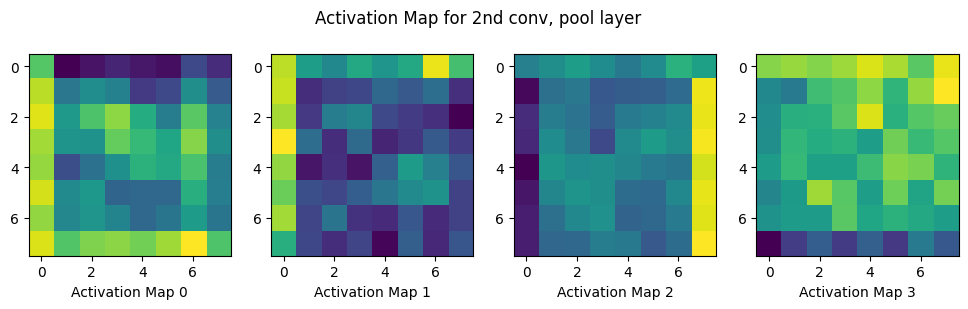


Epoch: 2


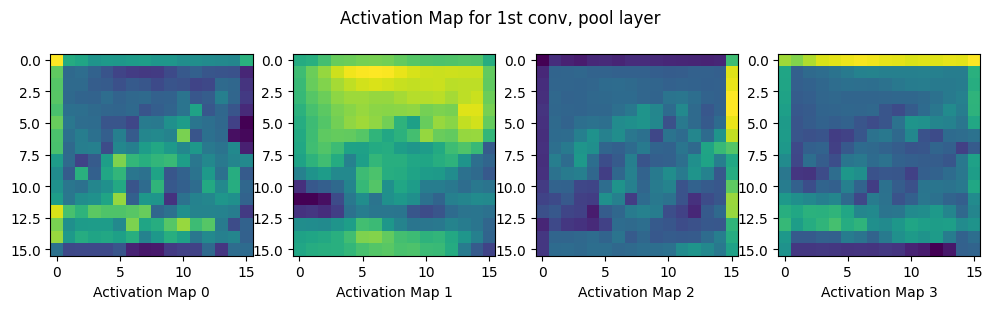

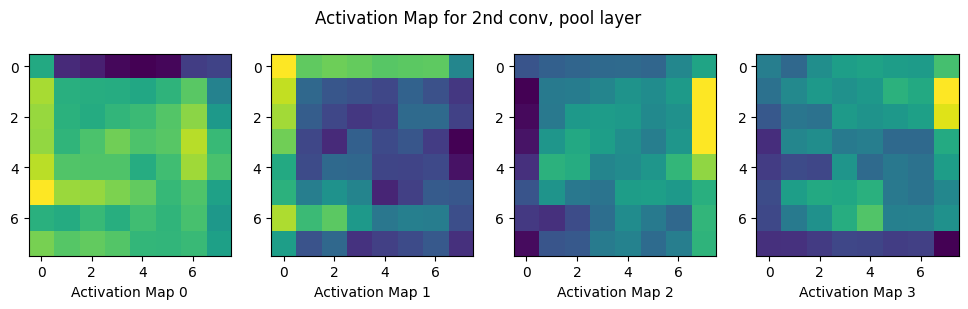


Epoch: 3


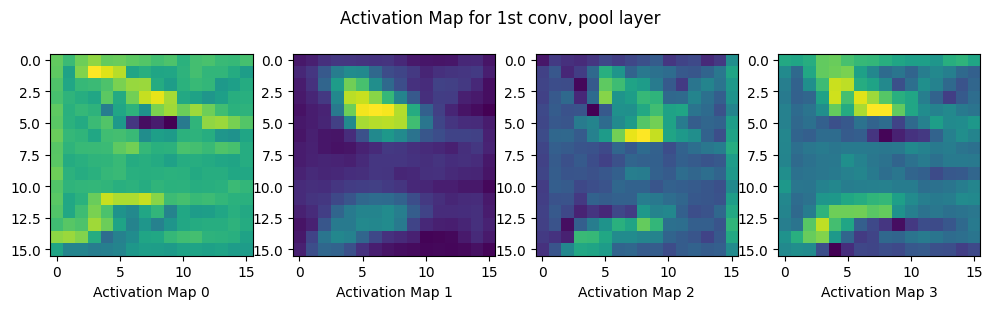

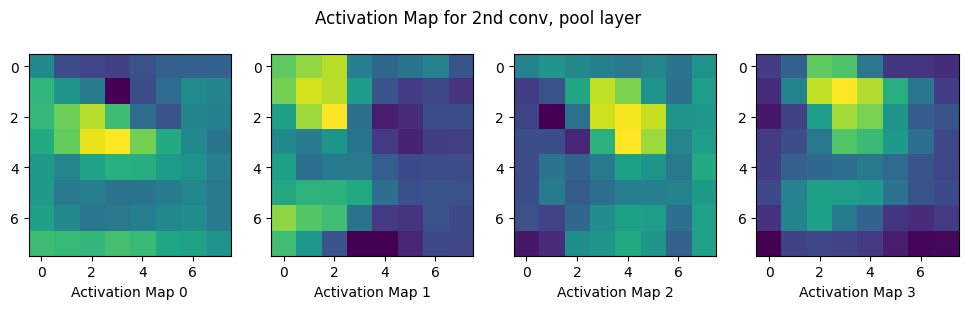


Epoch: 4


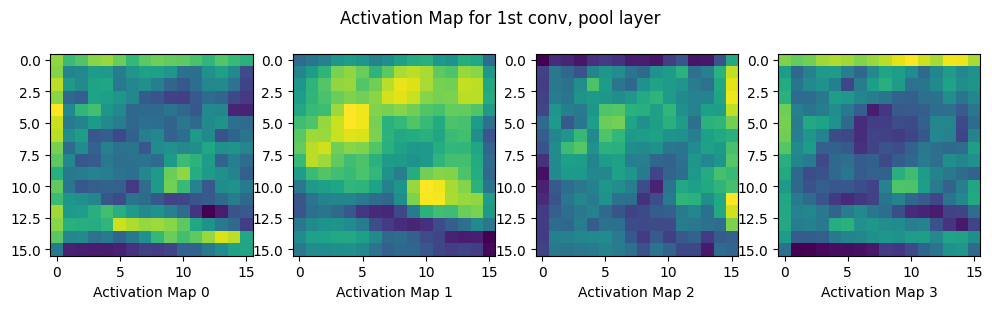

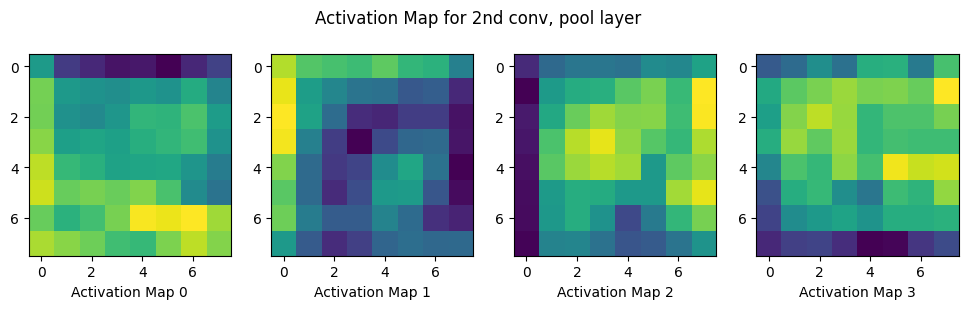


Epoch: 5


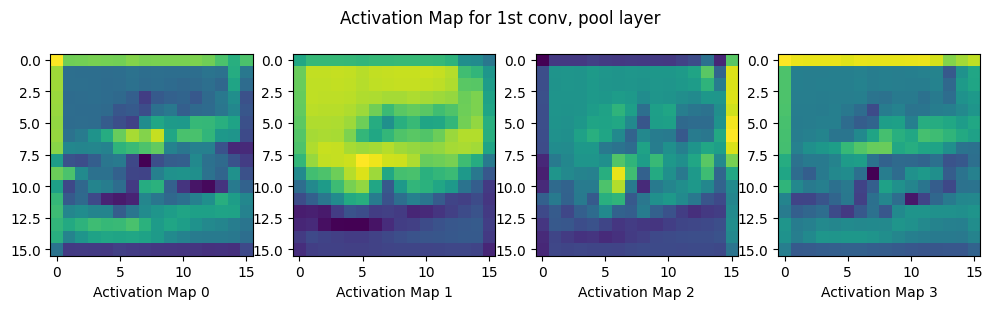

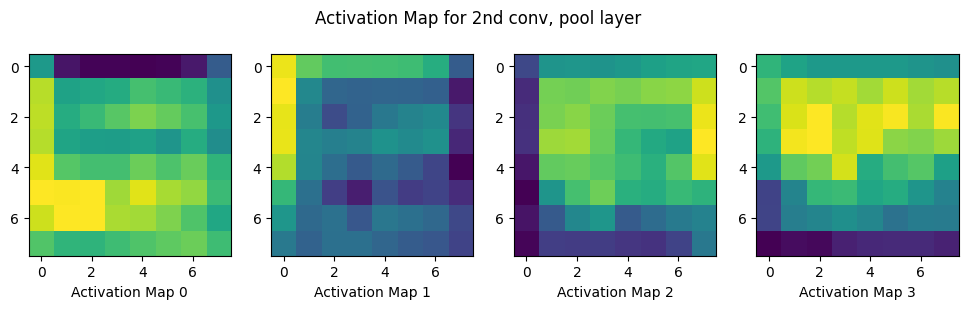


Epoch: 6


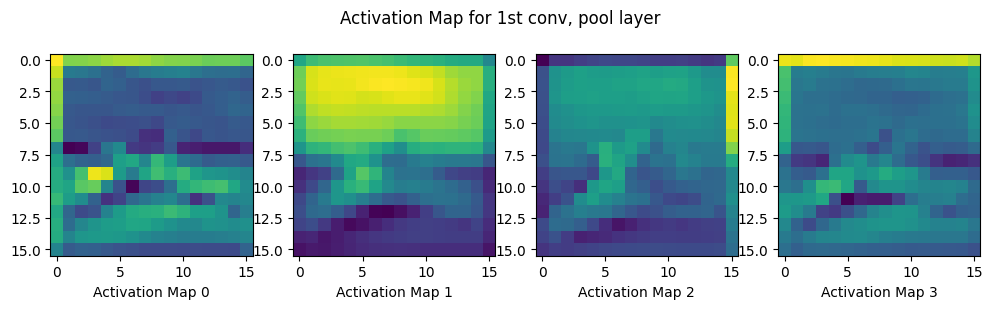

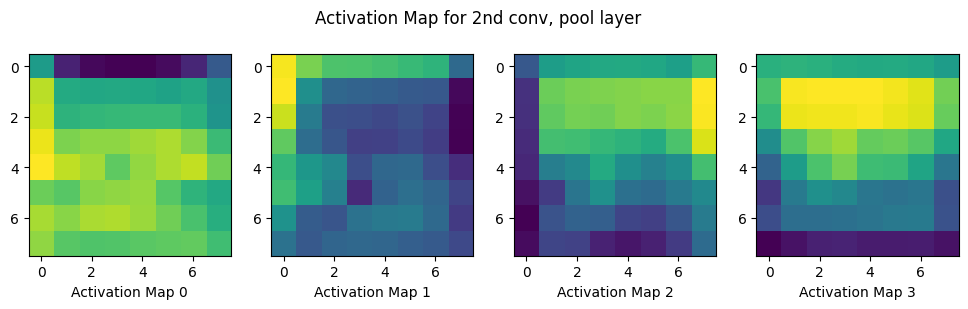


Epoch: 7


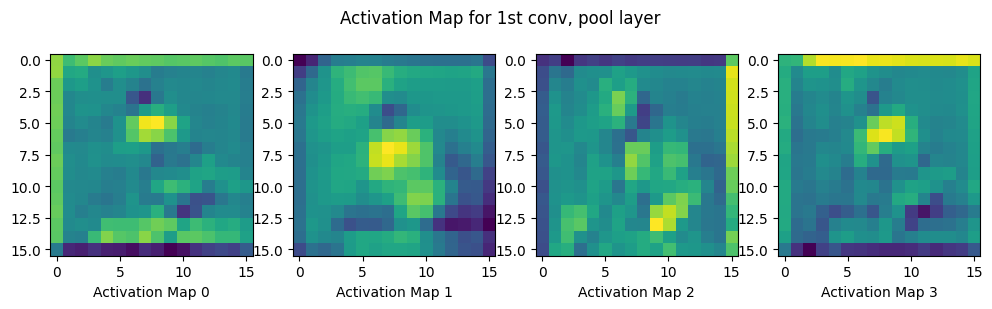

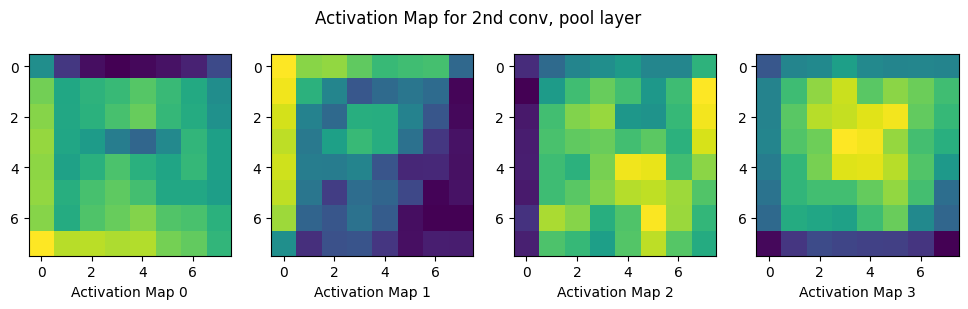


Epoch: 8


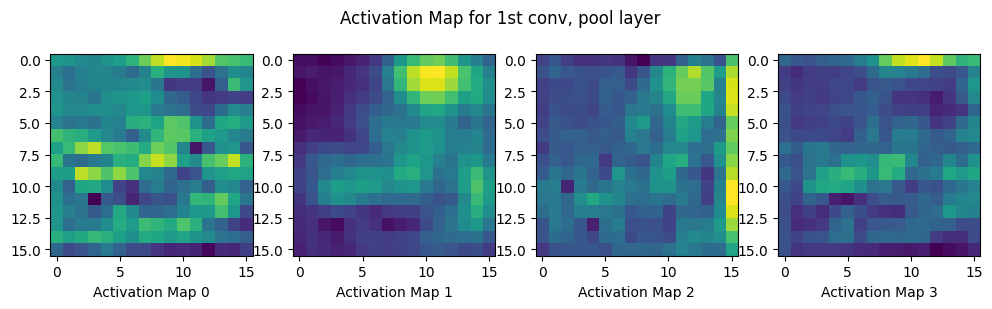

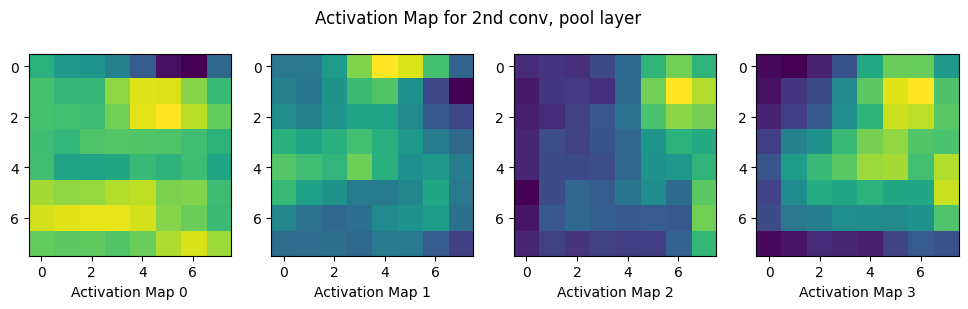


Epoch: 9


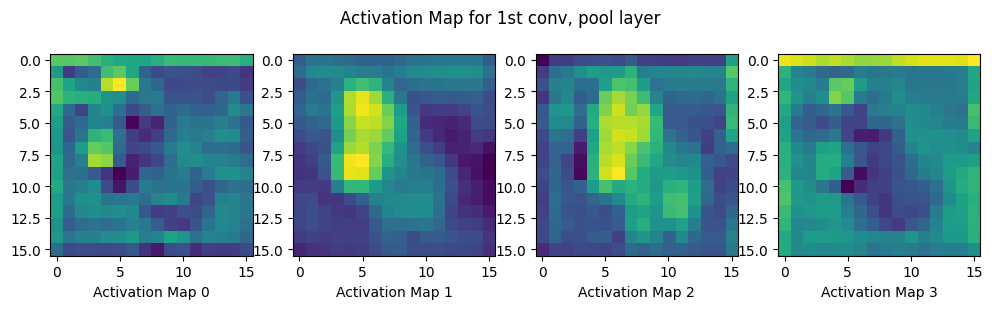

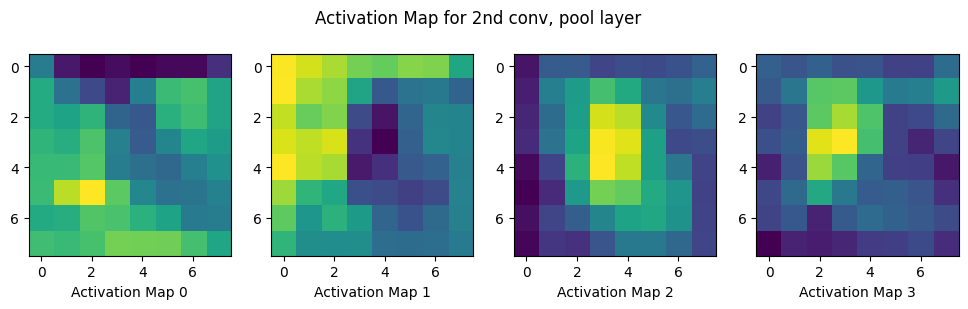


Epoch: 10


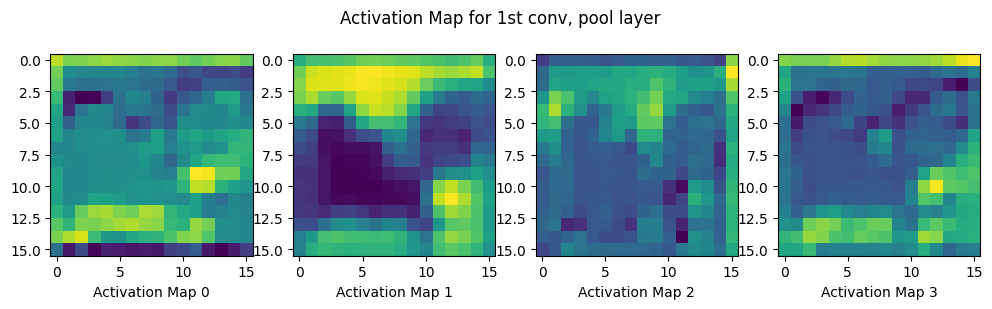

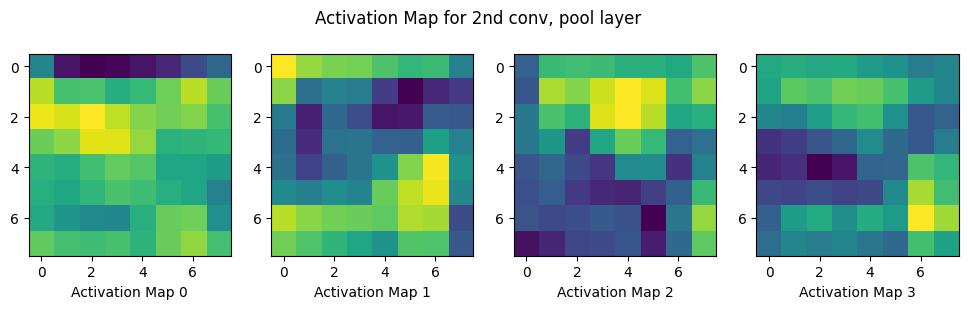


Epoch: 11


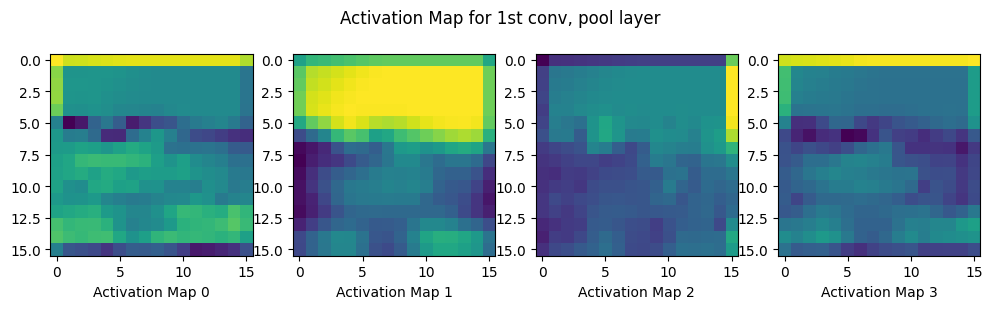

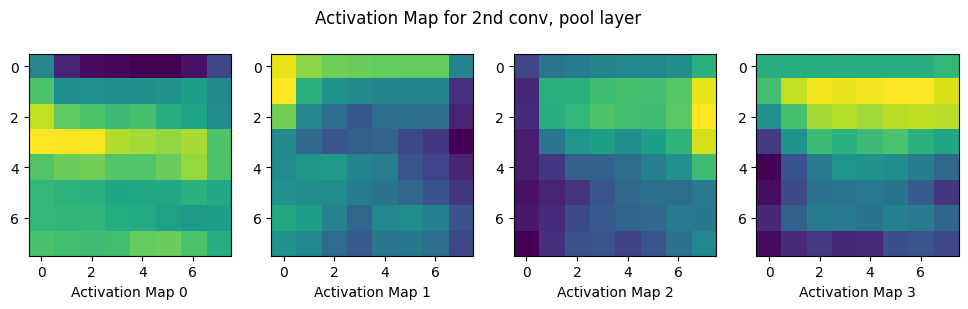


Epoch: 12


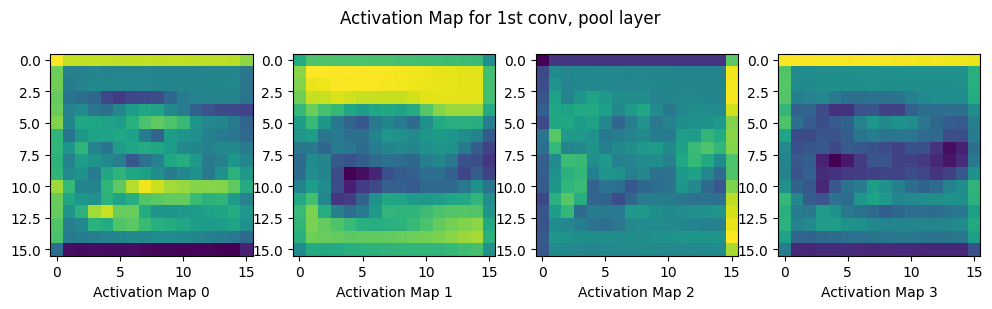

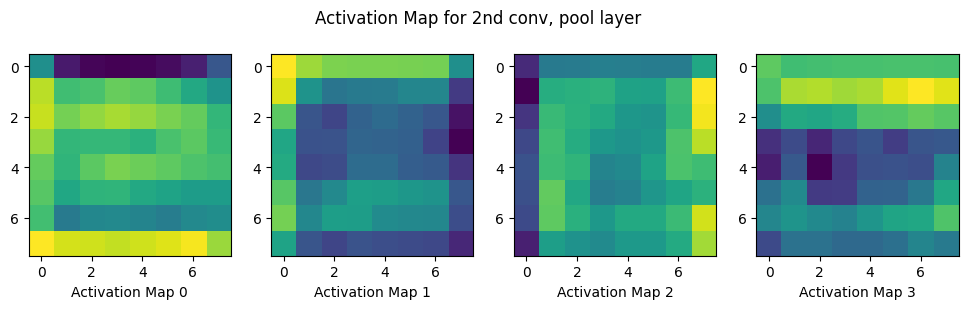


Epoch: 13


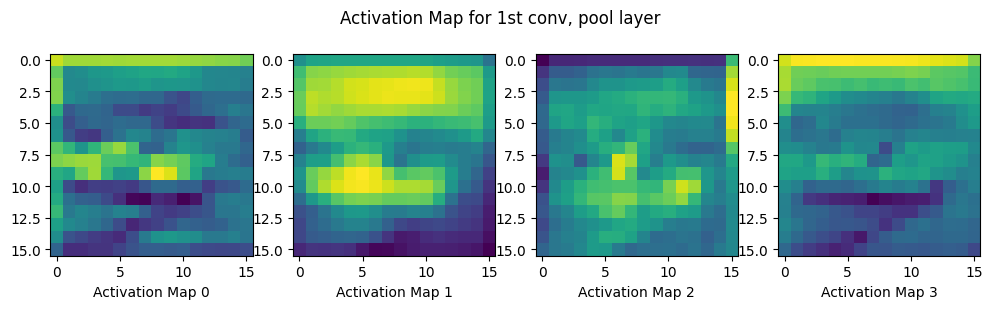

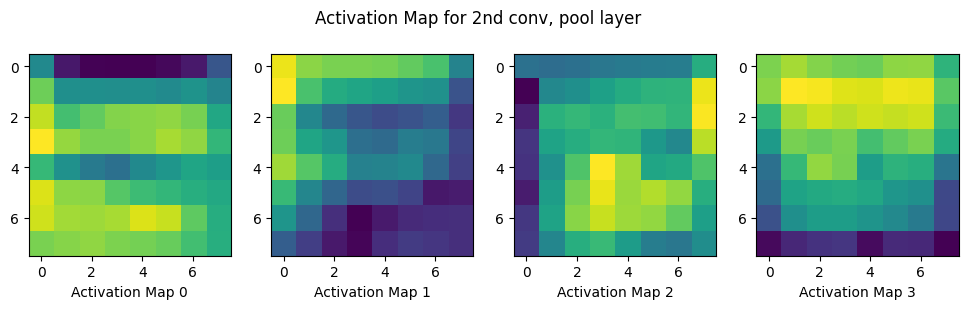


Epoch: 14


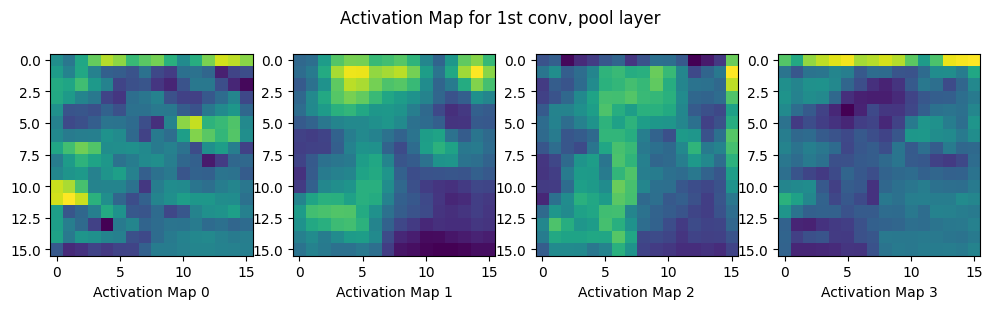

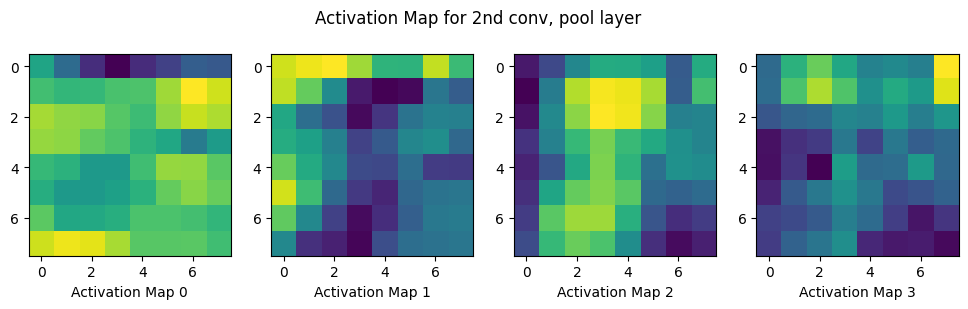

In [36]:
model = CNN_pytorch()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)
err_train, acc_train, err_test, acc_test = train(model, optimizer, criterion, X_tr, y_tr, batch_sz_train, n_epoch=15, batch_sz_test=batch_sz_test, plot_stat=True)

4. tSNE

Epoch: 0, Loss: 2.297452616691589, Accuracy: 0.123, Test Loss: 2.2878876447677614, Test Accuracy: 0.1
Epoch: 1, Loss: 2.2836288690567015, Accuracy: 0.122, Test Loss: 2.265222191810608, Test Accuracy: 0.19
Epoch: 2, Loss: 2.259535074234009, Accuracy: 0.155, Test Loss: 2.2255705833435058, Test Accuracy: 0.19
Epoch: 3, Loss: 2.211772322654724, Accuracy: 0.195, Test Loss: 2.2258063554763794, Test Accuracy: 0.15
Epoch: 4, Loss: 2.172610354423523, Accuracy: 0.176, Test Loss: 2.1536540150642396, Test Accuracy: 0.21
Epoch: 5, Loss: 2.1412740468978884, Accuracy: 0.206, Test Loss: 2.1248723149299624, Test Accuracy: 0.22
Epoch: 6, Loss: 2.102928102016449, Accuracy: 0.234, Test Loss: 2.1301106572151185, Test Accuracy: 0.23
Epoch: 7, Loss: 2.0821847677230836, Accuracy: 0.23, Test Loss: 2.057535481452942, Test Accuracy: 0.27
Epoch: 8, Loss: 2.0546560883522034, Accuracy: 0.244, Test Loss: 2.0456348657608032, Test Accuracy: 0.26
Epoch: 9, Loss: 2.022127854824066, Accuracy: 0.257, Test Loss: 2.05328086

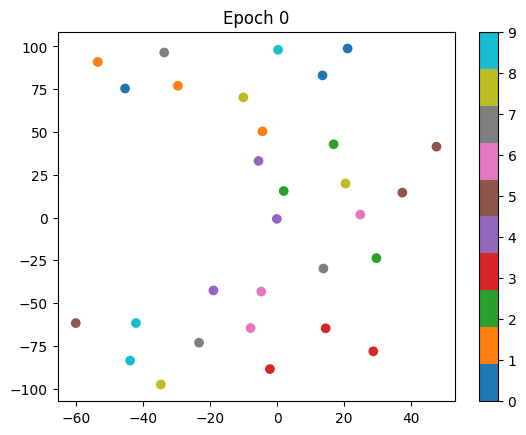

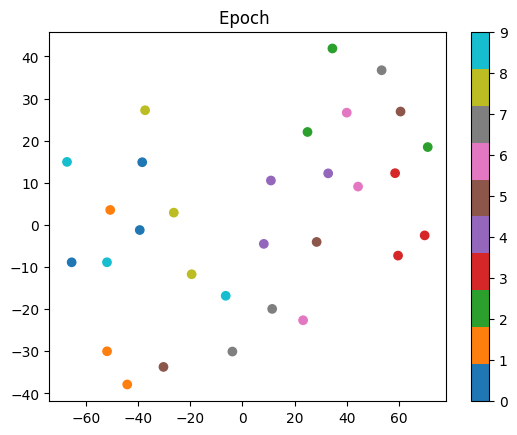

In [37]:
model = CNN_pytorch()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)

X_3, y_3 = get_data(x_train, y_train, 3)
out_3_ep_first = []
out_3 = []

_, _, _, _ = train(model, optimizer, criterion, X_tr, y_tr, 100, 1)
for i in range(len(X_3)):
    img = torch.tensor(X_3[i]).permute(2, 0, 1).unsqueeze(0).float()
    out = model.forward(img)
    out_3_ep_first.append(out.detach().numpy())

_, _, _, _ = train(model, optimizer, criterion, X_tr, y_tr, batch_sz_train, epochs, print_stats=True)

for i in range(len(X_3)):
    img = torch.tensor(X_3[i]).permute(2, 0, 1).unsqueeze(0).float()
    out = model.forward(img)
    out_3.append(out.detach().numpy())

# color for 10 classes
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']

# tsne
out_3_ep_first = np.concatenate(out_3_ep_first)
out_3 = np.concatenate(out_3)
out_embedded = TSNE(n_components=2, perplexity=10).fit_transform(out_3)
out_embedded_ep_first = TSNE(n_components=2, perplexity=10).fit_transform(out_3_ep_first)

plt.scatter(out_embedded_ep_first[:, 0], out_embedded_ep_first[:, 1], c=y_3, cmap='tab10')
plt.colorbar()
plt.title('Epoch 0')
plt.show()

plt.scatter(out_embedded[:, 0], out_embedded[:, 1], c=y_3, cmap='tab10')
plt.colorbar()
plt.title('Epoch ')
plt.show()



- Classes are coming closer to each other as compared to Epoch 0.
- But still are clearly separable from other classes. 

5. Droupout

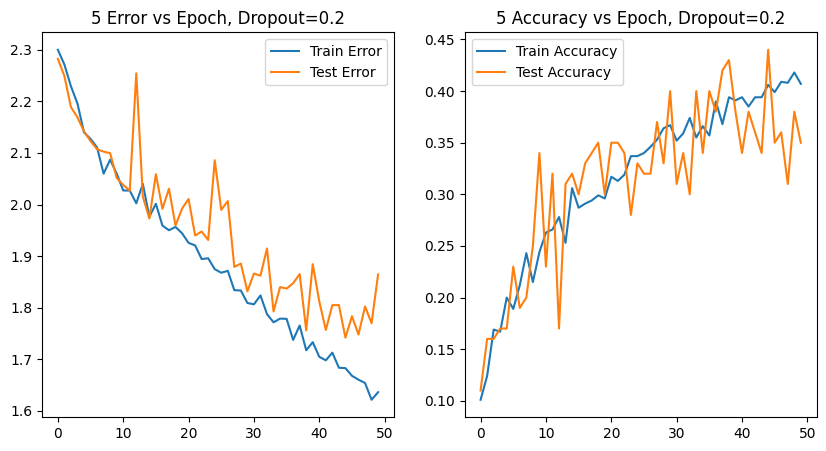

Final Train Accuracy after 50 epochs: 0.407
Final Test Accuracy after 50 epochs: 0.33


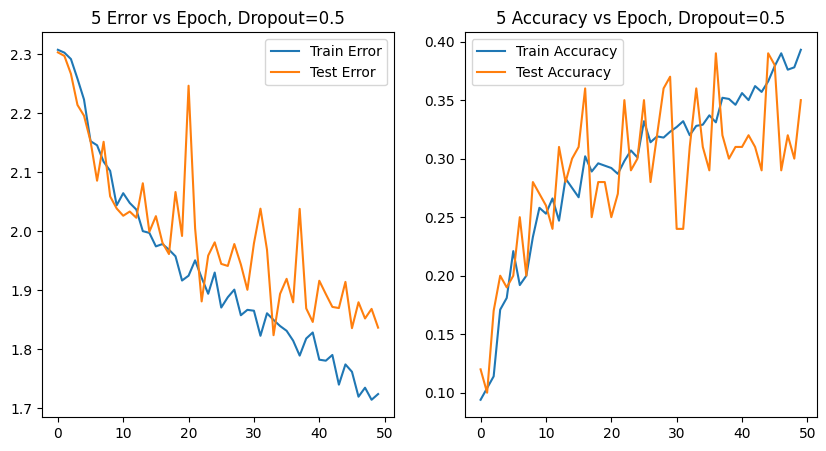

Final Train Accuracy after 50 epochs: 0.393
Final Test Accuracy after 50 epochs: 0.35


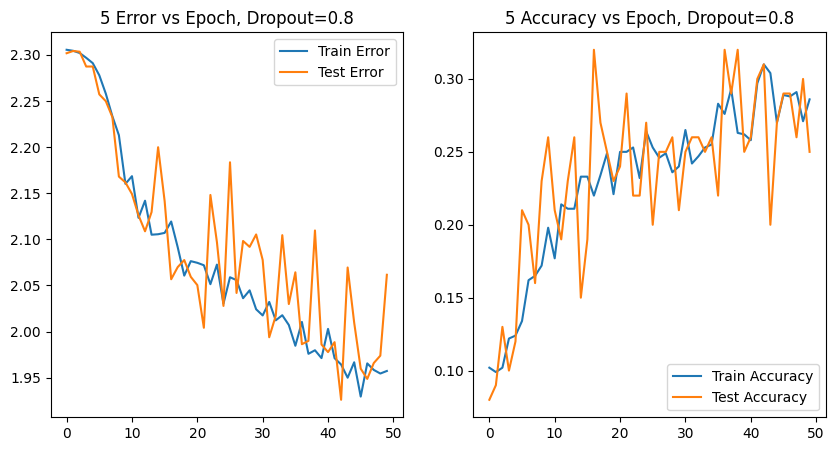

Final Train Accuracy after 50 epochs: 0.286
Final Test Accuracy after 50 epochs: 0.25


In [38]:
dropout = [0.2, 0.5, 0.8]

# train with dropout
for d in dropout:
    model = CNN_pytorch(dropout=d)
    optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)
    err_train, acc_train, err_test, acc_test = train(model, optimizer, criterion, X_tr, y_tr, batch_sz_train, epochs, batch_sz_test=batch_sz_test)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(err_train, label='Train Error')
    plt.plot(err_test, label='Test Error')
    plt.legend()
    plt.title(f'5 Error vs Epoch, Dropout={d}')

    plt.subplot(1, 2, 2)
    plt.plot(acc_train, label='Train Accuracy')
    plt.plot(acc_test, label='Test Accuracy')
    plt.legend()
    plt.title(f'5 Accuracy vs Epoch, Dropout={d}')

    plt.show()

    print(f'Final Train Accuracy after {epochs} epochs: {acc_train[-1]}')

    _, acc = test(model, X_te, y_te, batch_sz_test)
    print(f'Final Test Accuracy after {epochs} epochs: {acc}')


- For droupout with p=0.2 there is increase train and test accuracy as compared to model without dropout.
- For droupout with p=0.5, and p=0.8 there is decrease in train and test accuracy as compared to model without dropout.

6. Batch Normalization

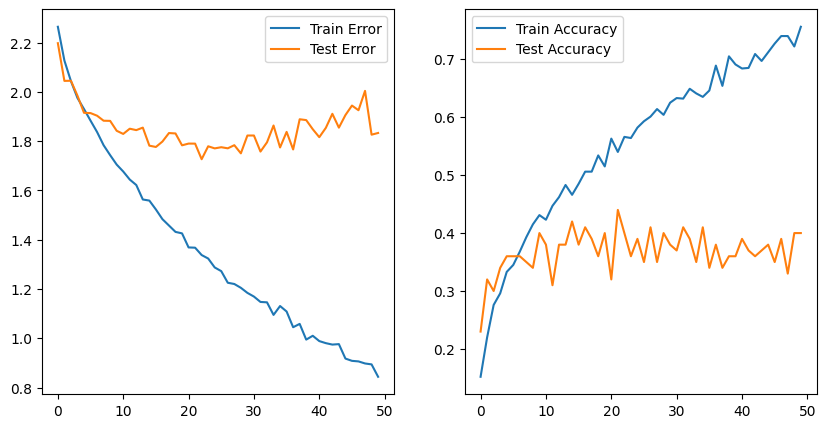

Final Train Accuracy after 50 epochs: 0.756
Final Test Accuracy after 50 epochs: 0.35


In [39]:
model = CNN_pytorch(dropout=0.2, batch_norm=True)
optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)
err_train, acc_train, err_test, acc_test = train(model, optimizer, criterion, X_tr, y_tr, batch_sz_train, epochs, batch_sz_test=batch_sz_test)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(err_train, label='Train Error')
plt.plot(err_test, label='Test Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_train, label='Train Accuracy')
plt.plot(acc_test, label='Test Accuracy')
plt.legend()

plt.show()

print(f'Final Train Accuracy after {epochs} epochs: {acc_train[-1]}')

_, acc = test(model, X_te, y_te, batch_sz_test)
print(f'Final Test Accuracy after {epochs} epochs: {acc}')

- Train accuracy improves by applying batch normalization as compared to model with dropout and vanilla model.
- Test accuracy is almost same for all models.